In [ ]:
import torch
import math
import matplotlib.pyplot as plt

In [ ]:
class SinActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))

        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(self.grid.T[self.spline_order:-self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        x = x.unsqueeze(-1)
        grid = self.grid
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1] +
                     (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1)
        )
        output = base_output + spline_output
        return output.reshape(*original_shape[:-1], self.out_features)


class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for in_f, out_f in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_f, out_f, grid_size, spline_order, scale_noise,
                                         scale_base, scale_spline, True,
                                         base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
#allocating the device on which the model runs - cuda (if available) allows pytorch to use GPU (it runs faster on gpu than cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#creating the model (with sizes as given in the paper in TABLE I) and moving it to the device
model = KAN([1,5,4,3,1]).to(device)

#optimizer with learning rate 0.0001 - the learning rate was adjusted such that the loss value was decreasing and good enough
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
#model.parameters() passes all the learnable parameters of the model to the optimizer

#using ExponentialLR scheduler to reduce (by 2% in this case) learning rate gradually to ensure that the model converges smoothly and avoid overshooting minima
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
#scheduler was removed since learning rate was already less and the scheduler was making it even lesser resulting in the loss being constant

#training data

#generating 100 input data points equally distributed between -1,1 and convert it to a 2d array and move to device
#requires_grad is set to true to ensure that all operations on the tensor are kept track of to calculate gradients later during backpropogation
N=100
x_train = torch.linspace(-1,1,N,requires_grad=True).view(-1,1).to(device)
x_bc = torch.tensor([[0.0]],requires_grad=True).to(device)
y_bc = torch.tensor([[1.0]]).to(device)

#training loop

#setting the epoch as mention in the paper in Section IV
epochs = 5000


for epoch in range(epochs):
  optimizer.zero_grad()
  y_pred = model(x_train)
  #y_pred has a size of [100,1]

  #grad_outputs=torch.ones_like(y_pred) - to ensure that all outputs (for each of the 100 inputs) have a equal weight of 1
  #create_graph = True - to keep the computation graph in case we need to calculate higher order derivatives later
  #the result is returned as a tuple with a single element and we just want the element so the [0]
  dydx = torch.autograd.grad(y_pred, x_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

  residual = dydx - 3*x_train**2
  physics_loss = (residual**2).mean()

  y_bc_pred = model(x_bc)
  bc_loss = (y_bc_pred - y_bc).pow(2).mean()

  loss = physics_loss + bc_loss

  loss.backward()
  #calculates the gradient of loss with respect to each parameter and these gradients are stored in the .grad attribute of each parameter

  optimizer.step() #updates model weights according to the gradients calculated
  #scheduler.step() #updates learning rate

  if epoch%500==0:
    print("Epoch",epoch,"----> loss:", loss.item())

  if loss.item() < target_loss:
    print("Target loss attained.")
    break

#model evaluation
model.eval()
x_test = torch.linspace(-1,1,200).view(-1,1).to(device)
y_test = model(x_test).detach().cpu().numpy()
x_test = x_test.cpu().numpy()
y_exact = x_test**3 + 1

Epoch 0 ----> loss: 2.771028518676758
Epoch 500 ----> loss: 1.876785397529602
Epoch 1000 ----> loss: 0.4598277807235718
Epoch 1500 ----> loss: 0.14457416534423828
Epoch 2000 ----> loss: 0.05704698711633682
Epoch 2500 ----> loss: 0.019241532310843468
Epoch 3000 ----> loss: 0.005769931245595217
Epoch 3500 ----> loss: 0.0021573875565081835
Epoch 4000 ----> loss: 0.0010359061416238546
Epoch 4500 ----> loss: 0.0005920096882618964


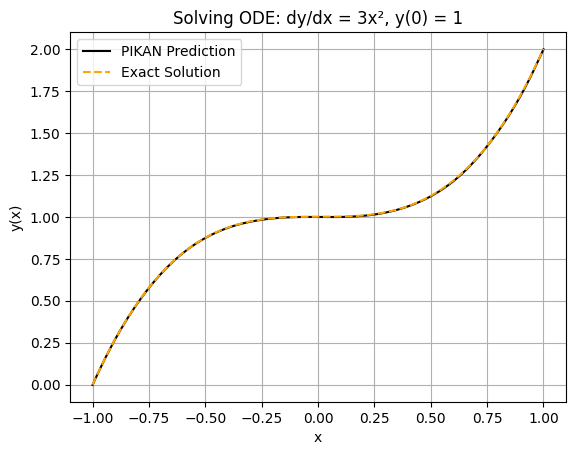

In [ ]:
#plot
plt.plot(x_test, y_test, label="PIKAN Prediction", color='black')
plt.plot(x_test, y_exact, label="Exact Solution", linestyle='dashed', color='orange')
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Solving ODE: dy/dx = 3x², y(0) = 1")
plt.legend()
plt.grid(True)
plt.show()